In [1]:
import os
from pathlib import Path
import pymol2
import chempy # from pymol installation
from pathlib import Path
from typing import List, Set, Dict, Tuple, Callable
import json
from rdkit.Chem import AllChem, Draw

target_name = 'A71EV2A'
root = Path(f'{target_name}')

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
import pandas as pd
import ipywidgets as wd


metadata: pd.DataFrame = pd.read_csv(root / 'metadata.csv',
                                     index_col=1)
out = wd.Output()
with out:  # suppress output the crappy way
    metadata['SMILES'] = metadata.new_smiles.apply(Chem.MolFromSmiles).apply(LargestFragmentChooser(preferOrganic=True).choose).apply(Chem.MolToSmiles)
metadata['notes'] = ''
metadata = metadata.rename(columns={'new_smiles': 'provided_smiles'}).copy()
metadata.iloc[0]

Unnamed: 0                               0
RealCrystalName              A71EV2A-x0451
smiles             CNC(=O)c1cn(C)c2ccccc12
new_smiles         CNC(=O)c1cn(C)c2ccccc12
alternate_name                  Z100643660
site_name                                1
pdb_entry                              NaN
SMILES             CNC(=O)c1cn(C)c2ccccc12
notes                                     
Name: A71EV2A-x0451_0A, dtype: object

In [2]:
combined_filename = root / (target_name + '_combined.sdf')
assert combined_filename.exists()

hits = []
choose_organic: Callable[[Chem.Mol,], Chem.Mol] = LargestFragmentChooser(preferOrganic=True).choose
with Chem.SDMolSupplier(combined_filename.as_posix()) as sdfh, out:
    for hit in sdfh:
        hits.append(choose_organic(hit))
        
assert len(hits) == len(metadata)

hitdex: Dict[str, Chem.Mol] = {h.GetProp('_Name'): h for h in hits}

In [3]:
# manually close cyclopropane ring in A71EV2A-x0473_0A

import numpy as np

mod = Chem.RWMol(hitdex['A71EV2A-x0473_0A'])
mod.AddBond(5, 4, Chem.BondType.SINGLE)
hitdex['A71EV2A-x0473_0A'] = mod.GetMol()
conf = hitdex['A71EV2A-x0473_0A'].GetConformer()
d = conf.GetAtomPosition(4).Distance(conf.GetAtomPosition(5))
metadata.at['A71EV2A-x0473_0A', 'notes'] = f'Manually closed cyclopropane ring! {d}Å'

In [4]:
def get_fixed(row: pd.Series):
    hit = hitdex[row.name]  # crystal name is index
    ref = Chem.MolFromSmiles(row.SMILES)
    #print(row.name)
    return AllChem.AssignBondOrdersFromTemplate(ref, hit)

metadata['crystal'] = metadata.apply(get_fixed, axis=1)

[10:22:52] WARNING: More than one matching pattern found - picking one



## RMSD

In [28]:
first_name = sorted(hitdex.keys())[0]
reference = root / 'aligned' / f'{first_name}' / f'{first_name}_bound.pdb'
assert reference.exists(), f'{reference} missing?'

import pymol2, re

rmsds: Dict[str, float] = {}
with pymol2.PyMOL() as pymol:
    pymol.cmd.load(reference, 'reference')
    for pdb in root.glob('**/*.pdb'):
        pymol.cmd.load(pdb.as_posix(), 'temp')
        rmsd = pymol.cmd.align('temp and chain A', 'reference')[0]
        pymol.cmd.delete('temp')
        name = pdb.parts[-1].replace(target_name + '_', '').replace('_bound.pdb', '')
        rmsds[name] = rmsd
        
metadata[f'RMSD_{first_name}'] = pd.Series(rmsds)

In [31]:
first_name = [k for k in hitdex.keys() if 'x0395_1A' in k][0]
reference = root / 'aligned' / f'{first_name}' / f'{first_name}_bound.pdb'
assert reference.exists(), f'{reference} missing?'

import pymol2, re

rmsds: Dict[str, float] = {}
with pymol2.PyMOL() as pymol:
    pymol.cmd.load(reference, 'reference')
    for pdb in root.glob('**/*.pdb'):
        pymol.cmd.load(pdb.as_posix(), 'temp')
        rmsd = pymol.cmd.align('temp and chain A', 'reference')[0]
        pymol.cmd.delete('temp')
        name = pdb.parts[-1].replace(target_name + '_', '').replace('_bound.pdb', '')
        rmsds[name] = rmsd
        
metadata[f'RMSD_{first_name}'] = pd.Series(rmsds)

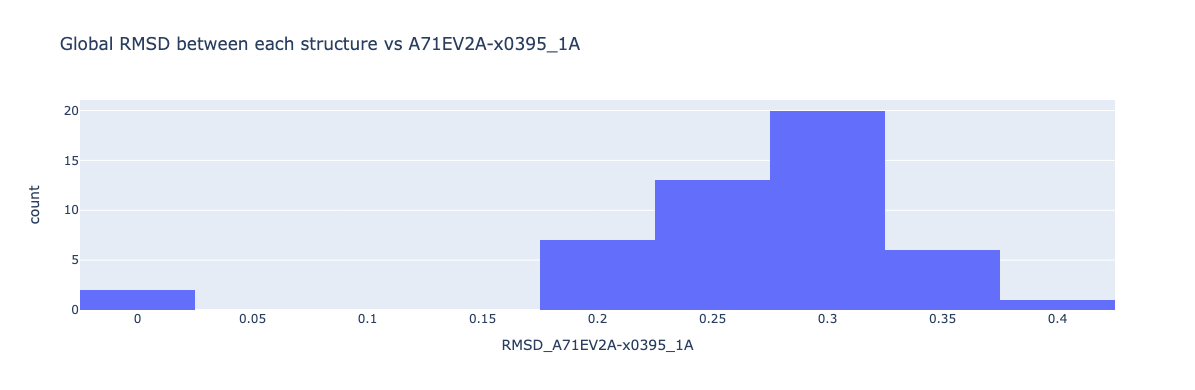

In [34]:
import plotly.express as px

px.histogram(metadata, 'RMSD_A71EV2A-x0395_1A', title=f'Global RMSD between each structure vs {first_name}')

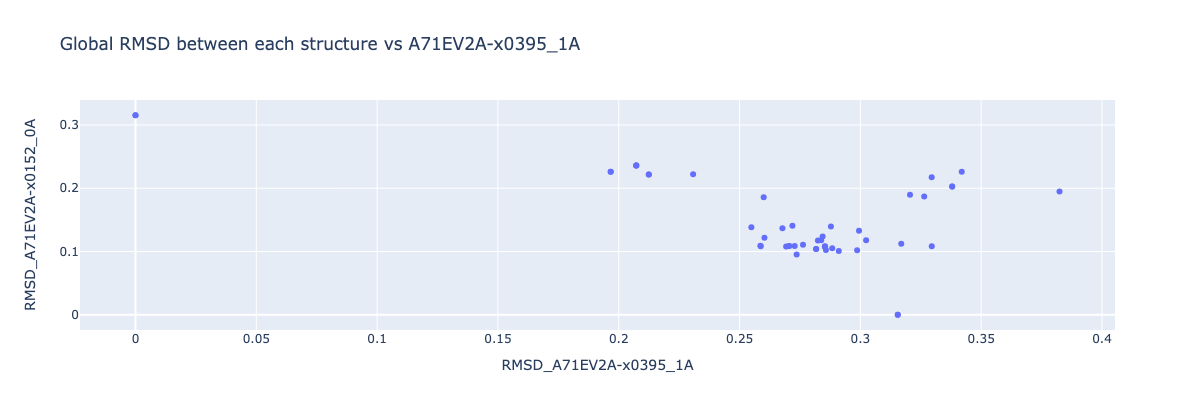

In [35]:
px.scatter(metadata, 'RMSD_A71EV2A-x0395_1A', 'RMSD_A71EV2A-x0152_0A', title=f'Global RMSD between each structure vs {first_name}')

## Pockets

In [ ]:
import numpy as np
import functools
import numpy.typing as npt

def get_mindist(molA: Chem.Mol, molB: Chem.Mol) -> float:
    d: npt.ArrayLike = AllChem.Get3DDistanceMatrix( Chem.CombineMols(molA, molB) )
    a = molA.GetNumAtoms()
    b = molB.GetNumAtoms()
    d[:a, :a] = d[:a, :a] * np.nan
    d[a:, a:] = d[a:, a:] * np.nan
    return np.nanmin(d)
    
for name, target in substrate_blocks.items():
    metadata[f'{name}_distance'] = metadata.crystal.apply(functools.partial(get_mindist, target))

In [6]:
import pymol2, re

substrate_blocks: Dict[str, Chem.Mol] = {}
key_parts = [('C110', 'chain A and resi 110'),
               ('H21', 'chain A and resi 21'), 
               ('D39', 'chain A and resi 39'),
               ('Y89', 'chain A and resi 89'),
               ('Y90', 'chain A and resi 90'),
               ('P2prime', 'chain C and resi 2'),
               ('P1prime', 'chain C and resi 1'), 
               ('P1', 'chain C and resi 0'), 
               ('P2', 'chain C and resi -1'),]
with pymol2.PyMOL() as pymol:
    pymol.cmd.load(reference, 'pos_reference')
    pymol.cmd.remove('not polymer')
    pdbblock = pymol.cmd.get_pdbstr('chain A')
    pymol.cmd.fetch('7DA6', 'reference')
    pymol.cmd.align('reference and chain A', 'pos_reference')
    pymol.cmd.delete('pos_reference')
    pymol.cmd.remove('solvent')
    substrate = Chem.MolFromPDBBlock(pymol.cmd.get_pdbstr('chain C'))
    substrate.SetProp('_Name', 'peptide')
    for name, sele in key_parts:
        substrate_blocks[name] = Chem.MolFromPDBBlock(pymol.cmd.get_pdbstr(sele))

 ExecutiveLoad-Detail: Detected mmCIF


In [66]:
metadata['XChem_code'] = metadata.index.to_series().str.replace('A71EV2A-', '')

In [76]:
import pymol2, re

distances: Dict[str, float] = {}

for pdb in root.glob('**/*.pdb'):
    with pymol2.PyMOL() as pymol:
        pymol.cmd.load(pdb.as_posix(), 'prot')
        name = pdb.parts[-1].replace(target_name + '_', '').replace('_bound.pdb', '')
        # Y89.OH-S125.O_distance
        distances[name] = pymol.cmd.distance('resi 89 and chain A and name OH', 'resi 125 and chain A and name O')
        if 'x0395_0A' in name:
            print(name)
            pymol.cmd.save('test.pse')
        
metadata['Y89.OH-S125.O_distance'] = distances

A71EV2A-x0395_0A


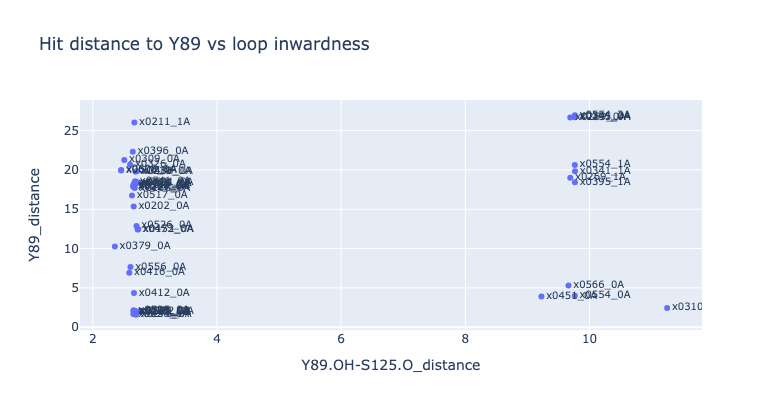

In [77]:
fig = px.scatter(metadata.drop_duplicates(), 'Y89.OH-S125.O_distance','Y89_distance',
           text='XChem_code',
           title='Hit distance to Y89 vs loop inwardness')

fig.update_traces(textposition='middle right', textfont_size=10)
fig

In [80]:
print(metadata.loc[metadata['Y89.OH-S125.O_distance'] < 9].XChem_code.to_list())

['x0469_0A', 'x0473_0A', 'x0486_0A', 'x0517_0A', 'x0525_0A', 'x0526_0A', 'x0540_0A', 'x0541_0A', 'x0556_0A', 'x0586_0A', 'x0278_0A', 'x0278_1A', 'x0305_0A', 'x0309_0A', 'x0326_0A', 'x0608_0A', 'x0608_1A', 'x0691_0A', 'x0152_0A', 'x0152_1A', 'x0188_0A', 'x0202_0A', 'x0211_0A', 'x0211_1A', 'x0211_2A', 'x0228_0A', 'x0229_0A', 'x0229_1A', 'x0239_0A', 'x0332_0A', 'x0354_0A', 'x0359_0A', 'x0379_0A', 'x0396_0A', 'x0412_0A', 'x0416_0A', 'x0428_0A']


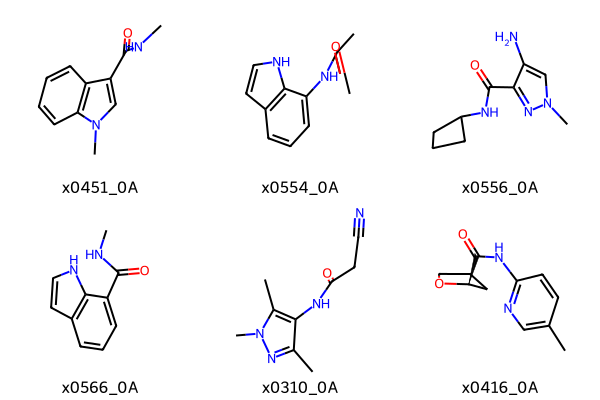

In [134]:
sub = metadata.loc[metadata['P1_distance'] < 2]
Draw.MolsToGridImage(sub.crystal, legends=sub.XChem_code.to_list())

In [110]:
with pymol2.PyMOL() as pymol:
    pymol.cmd.load(reference, 'reference')
    pymol.cmd.remove('resn LIG')
    pymol.cmd.bg_color('white')
    pymol.cmd.set('ray_trace_mode', 3)
    pymol.cmd.color('white', 'element C')
    pymol.cmd.show('sticks', 'chain A and resi 21+110+39+89+90')
    pymol.cmd.hide('nonbonded')
    for name, row in metadata.iterrows():
        pymol.cmd.read_molstr(Chem.MolToMolBlock(row.crystal), row.XChem_code)
        if row['Y89.OH-S125.O_distance'] > 9:
            pymol.cmd.color('0x40E0D0', f'{row.XChem_code} and element C')
        else:
            pymol.cmd.color('0xFA8072', f'{row.XChem_code} and element C')
    pymol.cmd.save('pose_typed.pse')

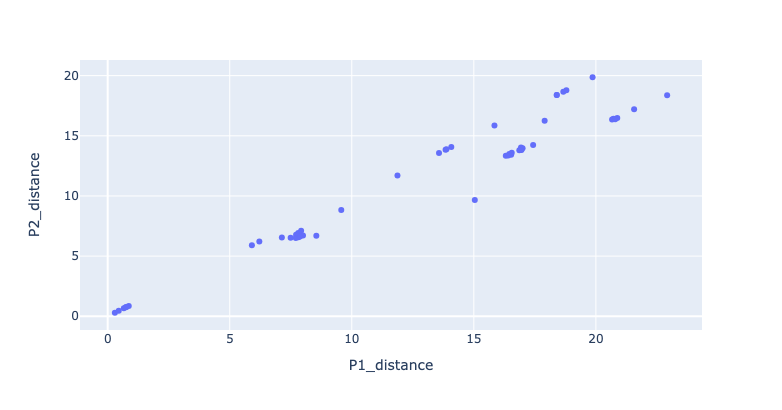

In [88]:
px.scatter(metadata, 'P1_distance', 'P2_distance')

In [91]:
metadata.loc[(metadata.P1_distance < 2) & (metadata.P2_distance < 2)].XChem_code.to_list()

['x0451_0A', 'x0554_0A', 'x0556_0A', 'x0566_0A', 'x0310_0A', 'x0416_0A']

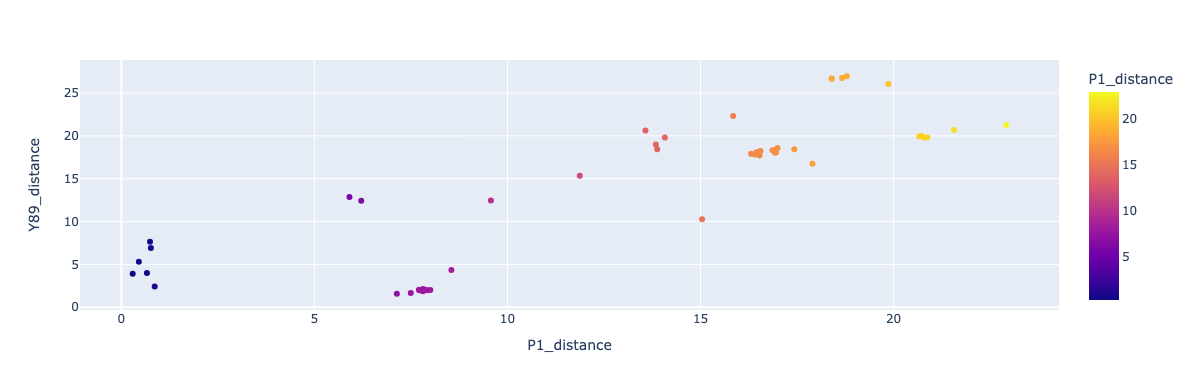

In [98]:
px.scatter(metadata, 'P1_distance', 'Y89_distance', color='P1_distance')

In [ ]:
metadata.sort_values('RMSD', ascending=False).head(10).round(2)[['alternate_name', 'RMSD', 'C110_distance', 'H21_distance', 'D39_distance', 'Y89_distance', 'Y90_distance']]

In [103]:
print(metadata.loc[(metadata.Y89_distance < 3) & (metadata.P1_distance > 2)].XChem_code.to_list())

['x0469_0A', 'x0525_0A', 'x0540_0A', 'x0278_0A', 'x0152_1A', 'x0211_0A', 'x0228_0A', 'x0229_1A', 'x0359_0A']


In [130]:
Chem.MolToMolFile(substrate, 'peptide.mol')

In [128]:
from rdkit.Chem import PandasTools

metadata['crystal_name'] = metadata.index
PandasTools.WriteSDF(metadata, 'clean_hits.sdf', 'crystal', 'crystal_name', allNumeric=True)
PandasTools.WriteSDF(metadata.loc[metadata['Y89.OH-S125.O_distance'] > 9], 'closed_hits.sdf', 'crystal', 'crystal_name', allNumeric=True)
PandasTools.WriteSDF(metadata.loc[metadata['P1_distance'] < 2], 'P1_hits.sdf', 'crystal', 'crystal_name', allNumeric=True)
PandasTools.WriteSDF(metadata.loc[(metadata['Y89_distance'] < 3) & (metadata['P1_distance'] > 2)], 'Y89_hits.sdf', 'crystal', 'crystal_name', allNumeric=True)

## Fragments

In [135]:
from gist_import import GistImporter
fmodule = GistImporter.from_github('https://raw.githubusercontent.com/matteoferla/Fragment-hit-follow-up-chemistry/main/followup/fragment.py')
remove_duplicated = fmodule['remove_duplicated']
fragmént = fmodule['fragmént']

frags = remove_duplicated( [frag for hit in metadata.loc[metadata['P1_distance'] < 2].crystal.to_list() + [substrate] for frag in fragmént(hit)] )

In [ ]:
from fragmenstein import Laboratory

with open('template.pdb') as fh:
    pdbblock = fh.read()

data = Laboratory.replace_hits(pdbblock, hits=frags, n_cores=2, timeout=600, suffix='')

In [139]:
data['fragement'] = data.name.str.contains('S')
data['XChem'] = ~data.name.str.contains('peptide')

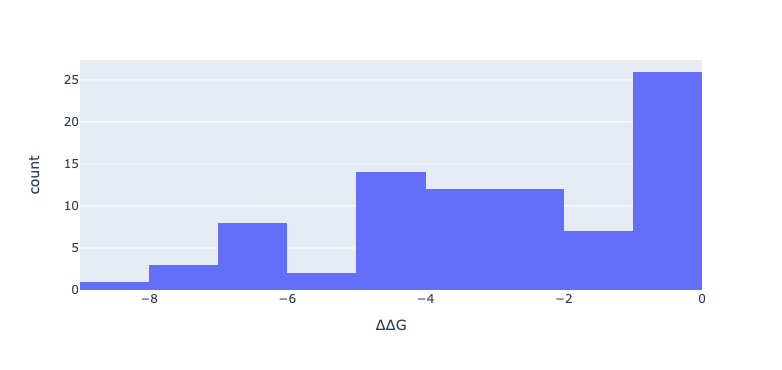

In [143]:
px.histogram(data, '∆∆G')

In [150]:
data.to_csv('fragmented_P1_data.csv')

In [148]:
import operator

hits = data.loc[(data['∆∆G'] <= -3) | (~data.fragement)].hit_mols.apply(operator.itemgetter(0)).to_list()

with Chem.SDWriter('fragmented_P1.sdf') as sdfh:
    for hit in hits:
        sdfh.write(hit)

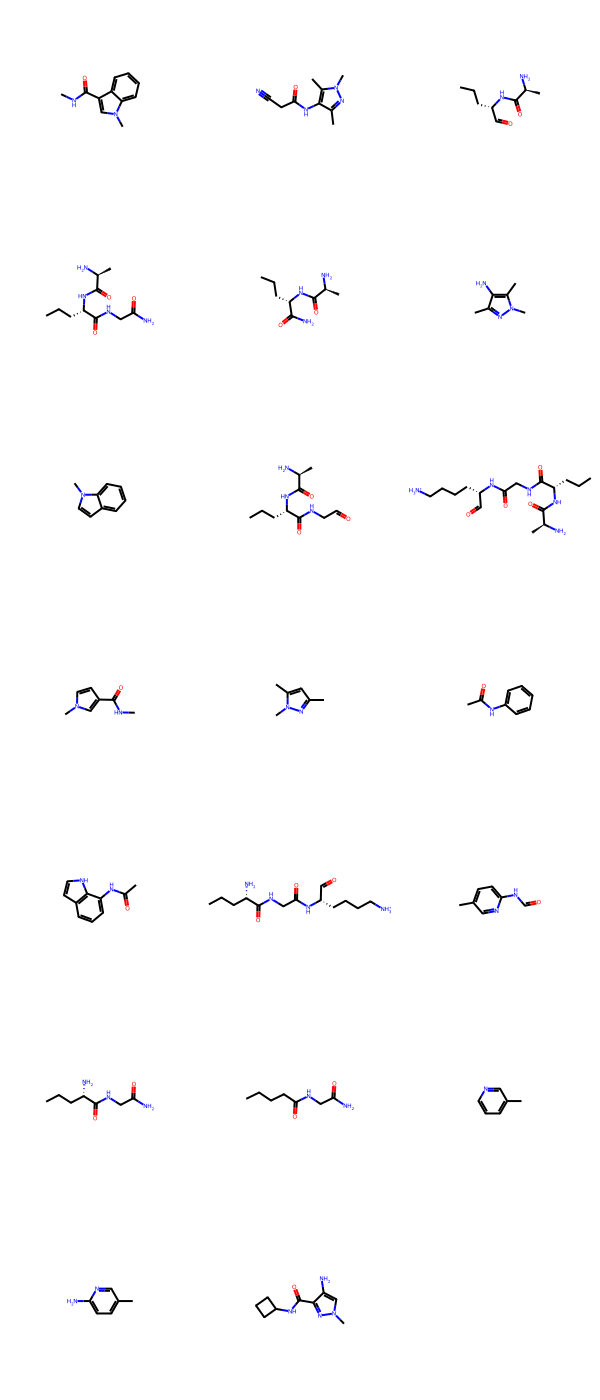

In [140]:
Draw.MolsToGridImage(data.sort_values('∆∆G').head(20).smiles.apply(Chem.MolFromSmiles))

In [85]:
data.loc[~data.fragement][['∆∆G', 'N_rotatable_bonds']]

,∆∆G,N_rotatable_bonds
0,-5.425538,3
5,-3.714017,4
8,-6.590541,3
13,-5.824892,4
18,-6.342973,5
28,-1.896181,2
31,-6.549449,2
34,-5.872293,4
43,-5.944017,8
46,-3.756799,2


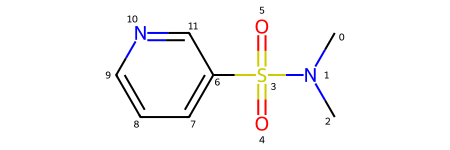

In [41]:
Chem.MolFromSmiles(metadata.set_index('crystal_name').loc['A71EV2A-x0428_0A'].SMILES)

In [6]:
for key in ('alternate_name', 'site_name', 'pdb_entry')
for hit in hits:

metadata.set_index('crystal_name', drop=True)[key].to_dict()







,RealCrystalName,smiles,new_smiles,alternate_name,site_name,pdb_entry,single_smiles
crystal_name,,,,,,,
A71EV2A-x0451_0A,A71EV2A-x0451,CNC(=O)c1cn(C)c2ccccc12,CNC(=O)c1cn(C)c2ccccc12,Z100643660,1,NaN,CNC(=O)c1cn(C)c2ccccc12
A71EV2A-x0469_0A,A71EV2A-x0469,CC(C)N1CCN(CC1)c2ncccn2,CC(C)N1CCN(CC1)c2ncccn2,Z104924088,1,NaN,CC(C)N1CCN(c2ncccn2)CC1
A71EV2A-x0473_0A,A71EV2A-x0473,O=S(=O)(NC1CCCC1)C2CCOCC2,O=S(=O)(NC1CCCC1)C2CCOCC2,Z1082839290,1,NaN,O=S(=O)(NC1CCCC1)C1CCOCC1
A71EV2A-x0486_0A,A71EV2A-x0486,CN(C)C(=O)Cn1ncc2ccccc12,CN(C)C(=O)Cn1ncc2ccccc12,Z1148165337,1,NaN,CN(C)C(=O)Cn1ncc2ccccc21
A71EV2A-x0517_0A,A71EV2A-x0517,CCn1cc(cn1)C(=O)NCc2ccc(F)cc2,CCn1cc(cn1)C(=O)NCc2ccc(F)cc2,Z1203107138,1,NaN,CCn1cc(C(=O)NCc2ccc(F)cc2)cn1
A71EV2A-x0525_0A,A71EV2A-x0525,FC(F)Oc1ccc(=O)[nH]c1,FC(F)Oc1ccc(=O)[nH]c1,Z1216861874,1,NaN,O=c1ccc(OC(F)F)c[nH]1
A71EV2A-x0526_0A,A71EV2A-x0526,Cc1nccn1c2cccnc2,Cc1nccn1c2cccnc2,Z1217131798,1,NaN,Cc1nccn1-c1cccnc1
A71EV2A-x0540_0A,A71EV2A-x0540,Fc1ccc(CNCc2ccc(C#N)cc2)cc1,Fc1ccc(CNCc2ccc(C#N)cc2)cc1,Z124039706,1,NaN,N#Cc1ccc(CNCc2ccc(F)cc2)cc1
A71EV2A-x0541_0A,A71EV2A-x0541,CC(Cc1c(C)noc1C)C(=O)N(C)C,CC(Cc1c(C)noc1C)C(=O)N(C)C,Z1246465616,1,NaN,Cc1noc(C)c1CC(C)C(=O)N(C)C
